In [1]:
import os
import argparse
import torch
import numpy as np
from models import build_model
from utils import get_dataset, backdoor_train, backdoor_evaluate, validation_per_class
from poisoned_dataset import create_backdoor_data_loader
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm.auto import tqdm
import time

In [2]:
np.arange(10)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [15]:
class global_args():
    None
global_args()

In [6]:
class args():
    dir = '/home/teun/internship/cluster/results/optimalize'
    datanames = ['mnist', 'emnist', 'fmnist']
    seed = 1
    epsilon = 0.1
    source_labels = np.arange(10)
    target_labels = np.arange(10)
    epsilons=[0.001, 0.005, 0.010, 0.015, 0.020]
    iid = "True"

In [51]:
torch.manual_seed(args.seed)
np.random.seed(args.seed)
device = torch.device('cpu')

data_dir = '/home/teun/internship/sniper-backdoor/data'

In [63]:
results_dir = '/home/teun/internship/cluster/results/mnist'
datanames = {'mnist': 5, 'emnist': 13, 'fmnist': 5}
results_dict = []
for iid in tqdm([True, False]):
    for dataname in tqdm(datanames.keys(),leave=False):
        for epsilon in tqdm(args.epsilons,leave=False):
            for personalized in [True, False]:
                if personalized:
                    path = os.path.join(
                                    results_dir, 
                                    f'{dataname}_{epsilon}_{args.source_label}->{args.target_label}'
                                    f'_iid_{iid}_finetuned_results.pt'
                                        )
                else:
                    path = path = os.path.join(
                                    results_dir, 
                                    f'{dataname}_{epsilon}_{args.source_label}->{args.target_label}'
                                    f'_iid_{iid}_backdoor_results.pt')
                model = torch.load(path, weights_only=False, map_location=device)

                clean_per_class = model['clean_per_class']
                poisoned_per_class = model['poisoned_per_class']
                asr = float(model['asr'])
                cad = float(model['cad'])
                if iid:
                    set_iid = 'IID'
                else:
                    set_iid = 'Non-IID'

                results_dict.append({'iid': set_iid, 'dataname': dataname.upper(), 'epsilon': epsilon, 'personalized': personalized,
                                    'clean_per_class': clean_per_class, 
                                    'poisoned_per_class': poisoned_per_class, 'asr': asr, 'cad': cad})        

In [64]:
torch.manual_seed(args.seed)
np.random.seed(args.seed)
device = torch.device('cpu')

data_dir = '/home/teun/internship/sniper-backdoor/data'

In [ ]:
try:
    backdoor_df = pd.read_csv('multiple_runs.csv')
except:
    results_dir = '/home/teun/internship/cluster/results/multiple_targets'
    datanames = {'mnist': 5, 'emnist': 13, 'fmnist': 5}
    results_dict = []
    for iid in tqdm([True, False]):
        for dataname in tqdm(datanames.keys(),leave=False):
            for epsilon in tqdm(args.epsilons,leave=False):
                for personalized in [True, False]:
                    for target in tqdm(args.target_labels,leave=False):
                        for source in tqdm(args.source_labels,leave=False):
                            if target==source:
                                continue
                            if personalized:
                                path = os.path.join(
                                                results_dir, 
                                                f'{dataname}_{epsilon}_{source}->{target}'
                                                f'_iid_{iid}_finetuned_results.pt'
                                                    )
                            else:
                                path = path = os.path.join(
                                                results_dir, 
                                                f'{dataname}_{epsilon}_{source}->{target}'
                                                f'_iid_{iid}_backdoor_results.pt')
                            model = torch.load(path, weights_only=False, map_location=device, )

                            clean_per_class = model['clean_per_class']
                            poisoned_per_class = model['poisoned_per_class']
                            asr = float(model['asr'])
                            cad = float(model['cad'])
                            if iid:
                                set_iid = 'IID'
                            else:
                                set_iid = 'Non-IID'

                            results_dict.append({'iid': set_iid, 'dataname': dataname.upper(), 'epsilon': epsilon, 'personalized': personalized,
                                                'clean_per_class': clean_per_class, 
                                                'poisoned_per_class': poisoned_per_class, 'asr': asr, 'cad': cad})      
    backdoor_df = pd.DataFrame(results_dict)
    backdoor_df.to_csv('multiple_runs.csv', index=False)  

<>:10: SyntaxWarning: invalid escape sequence '\e'
<>:10: SyntaxWarning: invalid escape sequence '\e'
/tmp/ipykernel_7070/1559829924.py:10: SyntaxWarning: invalid escape sequence '\e'
  g.set_xlabels('$\epsilon$')


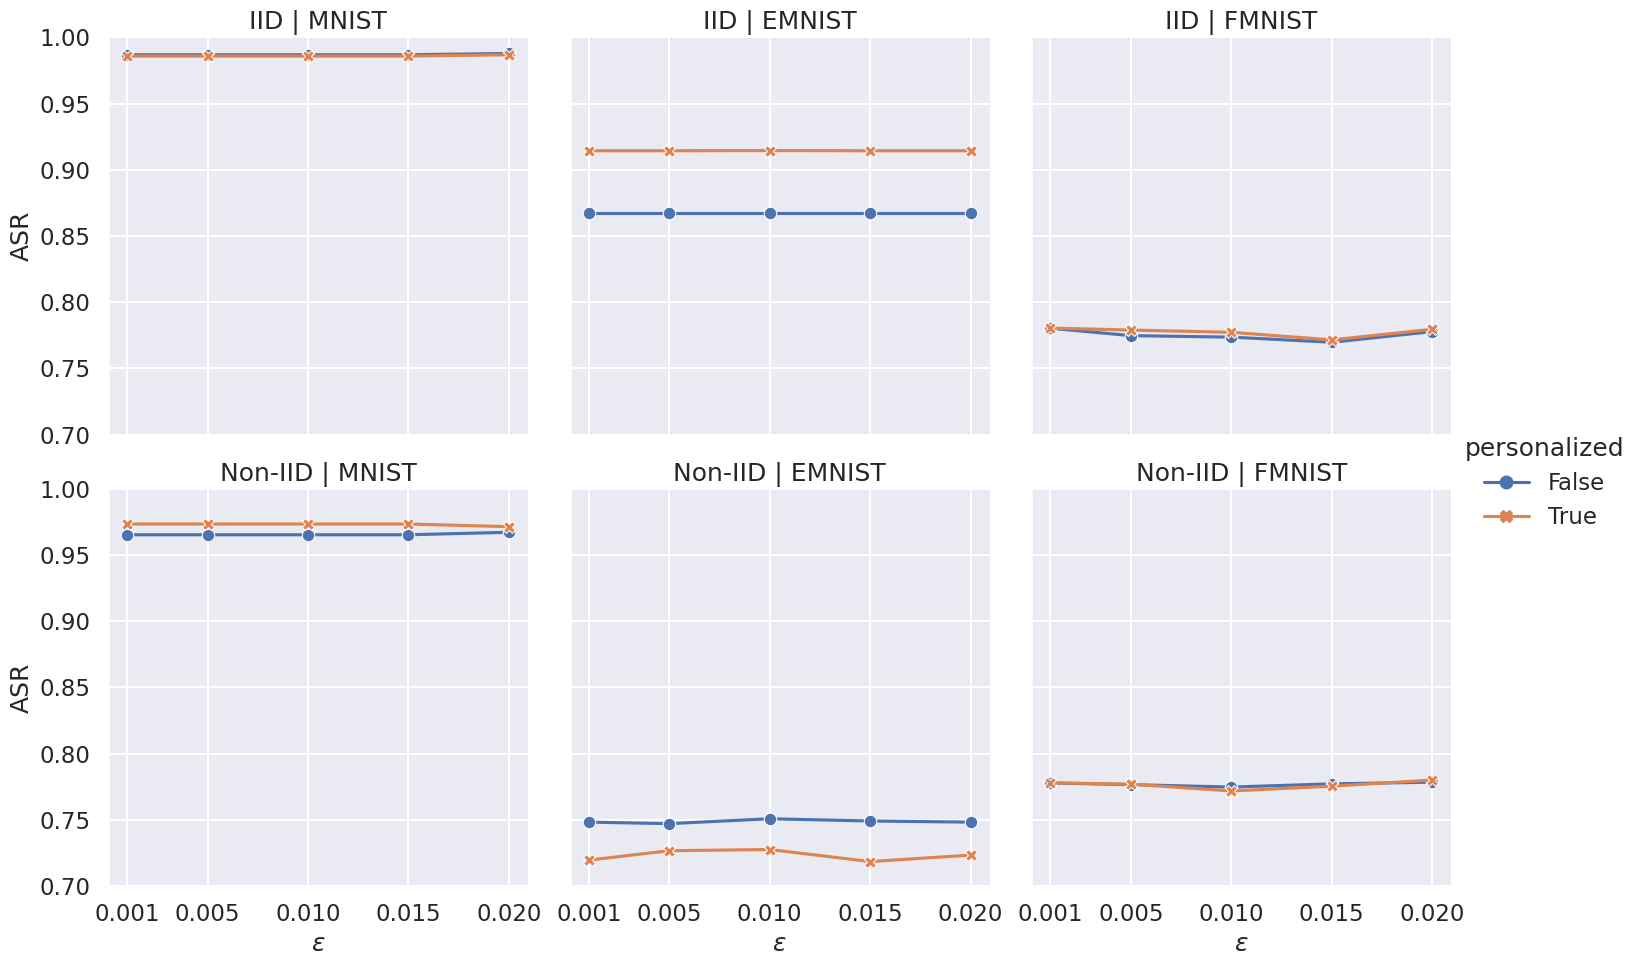

In [74]:
sns.set_theme(style='darkgrid')
sns.color_palette('colorblind')
sns.set_context('talk')
g = sns.relplot(data=backdoor_df, kind='line',
            x='epsilon', y='asr', hue='personalized', style='personalized', col='dataname', row='iid',
            dashes=False, markers=True)
plt.xticks([0.001, 0.005, 0.010, 0.015, 0.020])
plt.ylim([0.7, 1])
g.set_ylabels('ASR')
g.set_xlabels('$\epsilon$')
g.set_titles(col_template='{col_name}', row_template='{row_name}')
g.savefig('../asr.png')

<>:7: SyntaxWarning: invalid escape sequence '\e'
<>:7: SyntaxWarning: invalid escape sequence '\e'
/tmp/ipykernel_7070/1955334767.py:7: SyntaxWarning: invalid escape sequence '\e'
  g.set_xlabels('$\epsilon$')


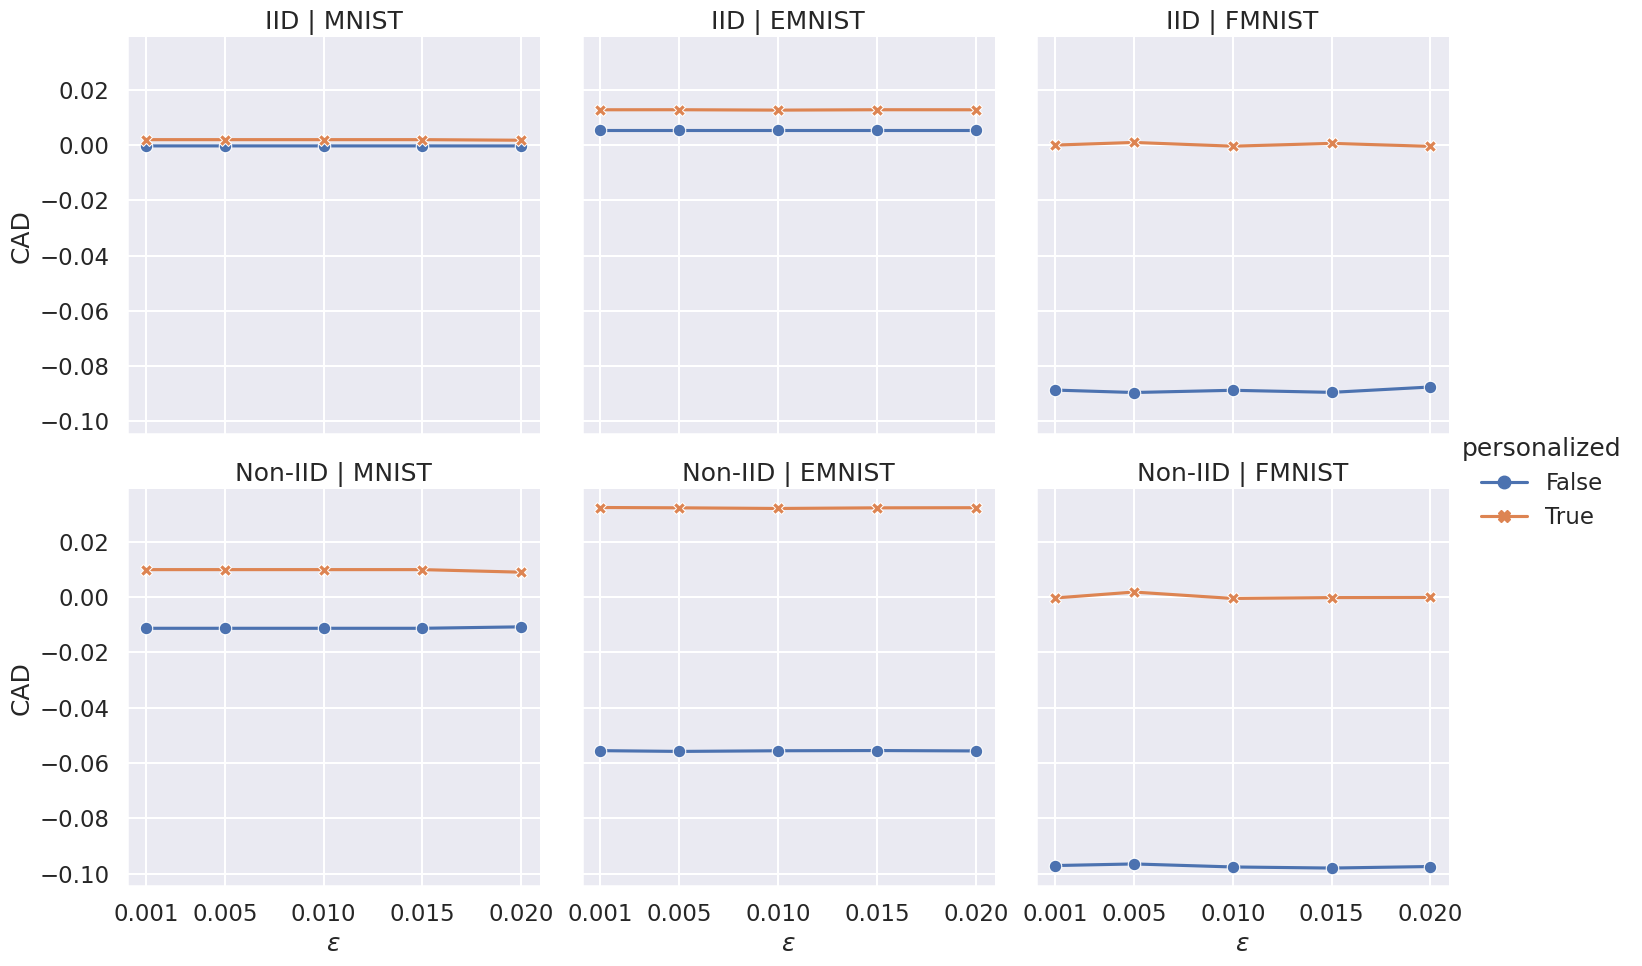

In [75]:
g = sns.relplot(data=backdoor_df, kind='line',
            x='epsilon', y='cad', hue='personalized', style='personalized', col='dataname', row='iid',
            dashes=False, markers=True)
plt.xticks([0.001, 0.005, 0.010, 0.015, 0.020])
plt.yticks(np.linspace(0.02,-0.10,7))
g.set_ylabels('CAD')
g.set_xlabels('$\epsilon$')
g.set_titles(col_template='{col_name}', row_template='{row_name}')
g.savefig('../cad.png')

In [67]:
results_dir = '/home/teun/internship/cluster/results/optimalize'
datanames = {'mnist': 5, 'emnist': 13, 'fmnist': 5}
results_dict = []
for iid in tqdm([True, False]):
    for dataname in tqdm(datanames.keys(),leave=False):
        for client in tqdm(range(datanames[dataname]),leave=False):

            path = os.path.join(
                results_dir, f'{dataname}_iid_{iid}_client_{client}_results.pt')
            server_model = torch.load(path, weights_only=False, map_location=device)

            train_loss = server_model['train_loss']
            train_acc = server_model['train_acc']
            test_loss = server_model['test_loss']
            test_acc = server_model['test_acc']
            train_epochs = np.arange(len(train_loss))
            test_epochs = np.linspace(1,len(train_epochs)-1,len(test_loss))
            if iid:
                set_iid = 'IID'
            else:
                set_iid = 'Non-IID'
            results_dict.append({'iid': set_iid, 'dataname': dataname.upper(), 'client': client, 'mode': 'train',
                                 'loss': train_loss, 'acc': train_acc, 'epochs': train_epochs})
            results_dict.append({'iid': set_iid, 'dataname': dataname.upper(), 'client': client, 'mode': 'test',
                                 'loss': test_loss, 'acc': test_acc, 'epochs': test_epochs})
            
        path = os.path.join(
            results_dir, f'{dataname}_iid_{iid}_server_results.pt')
        server_model = torch.load(path, weights_only=False, map_location=device)

        test_loss = server_model['loss']
        test_acc = server_model['acc']

        results_dict.append({'iid': set_iid, 'dataname': dataname.upper(), 'client': None, 'mode': 'test',
                             'loss': test_loss, 'acc': test_acc, 'epochs': np.arange(len(test_loss))})

        

In [68]:
df = pd.DataFrame(results_dict)
df = df.explode(['loss', 'acc', 'epochs'], ignore_index=True)
df['loss'] = df['loss'].astype(float)

In [69]:
train = df[df['mode']=='train']
server = df[(df['client'].isna()) & (df['mode']=='test')]

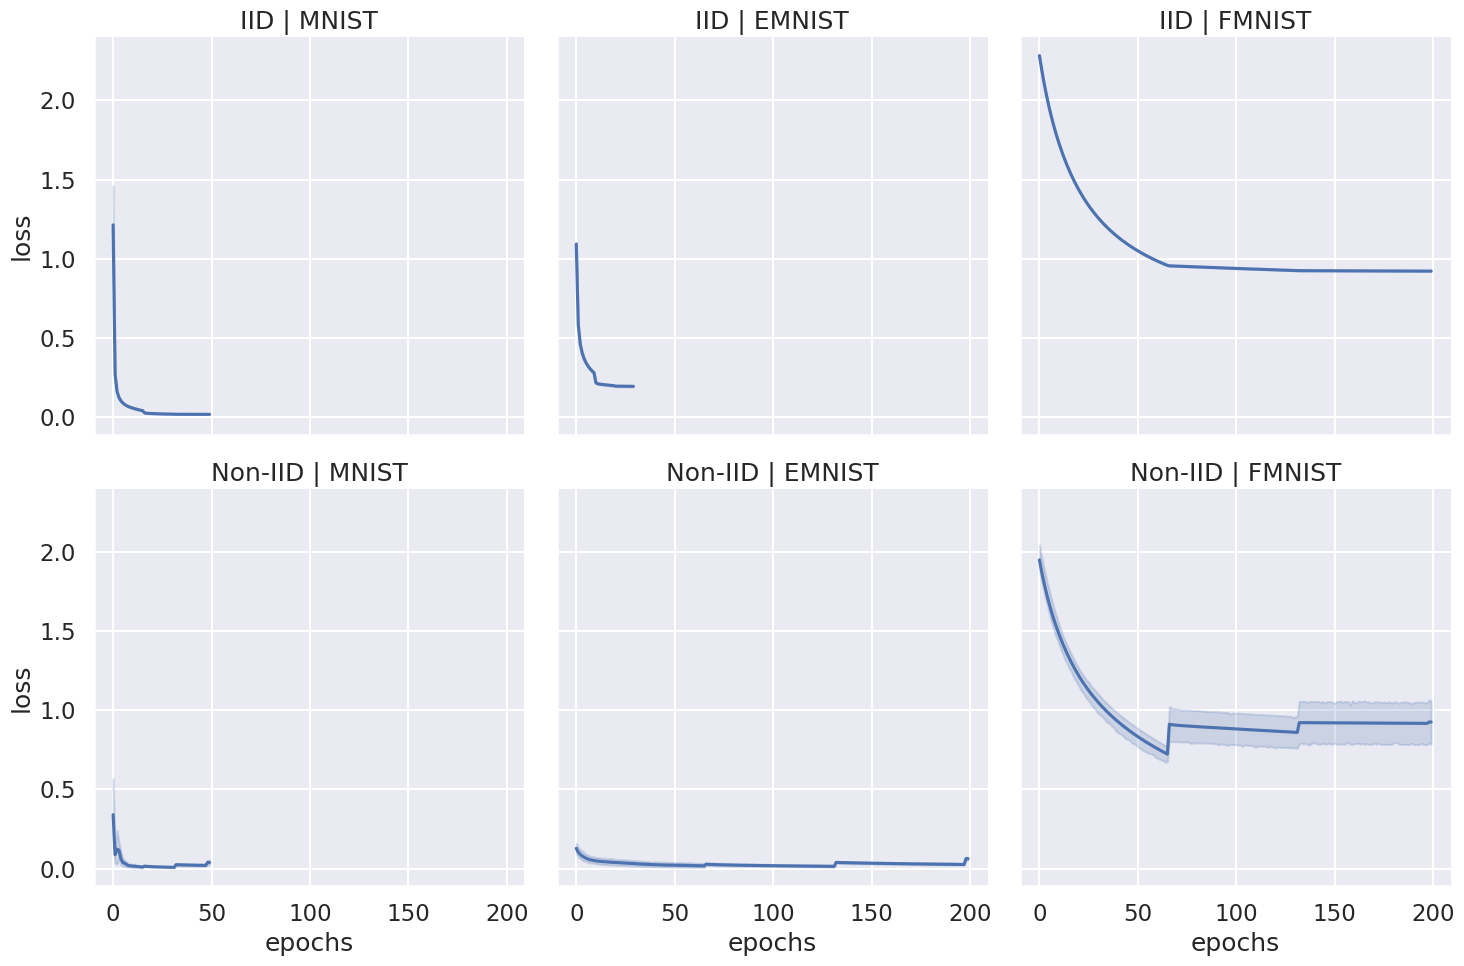

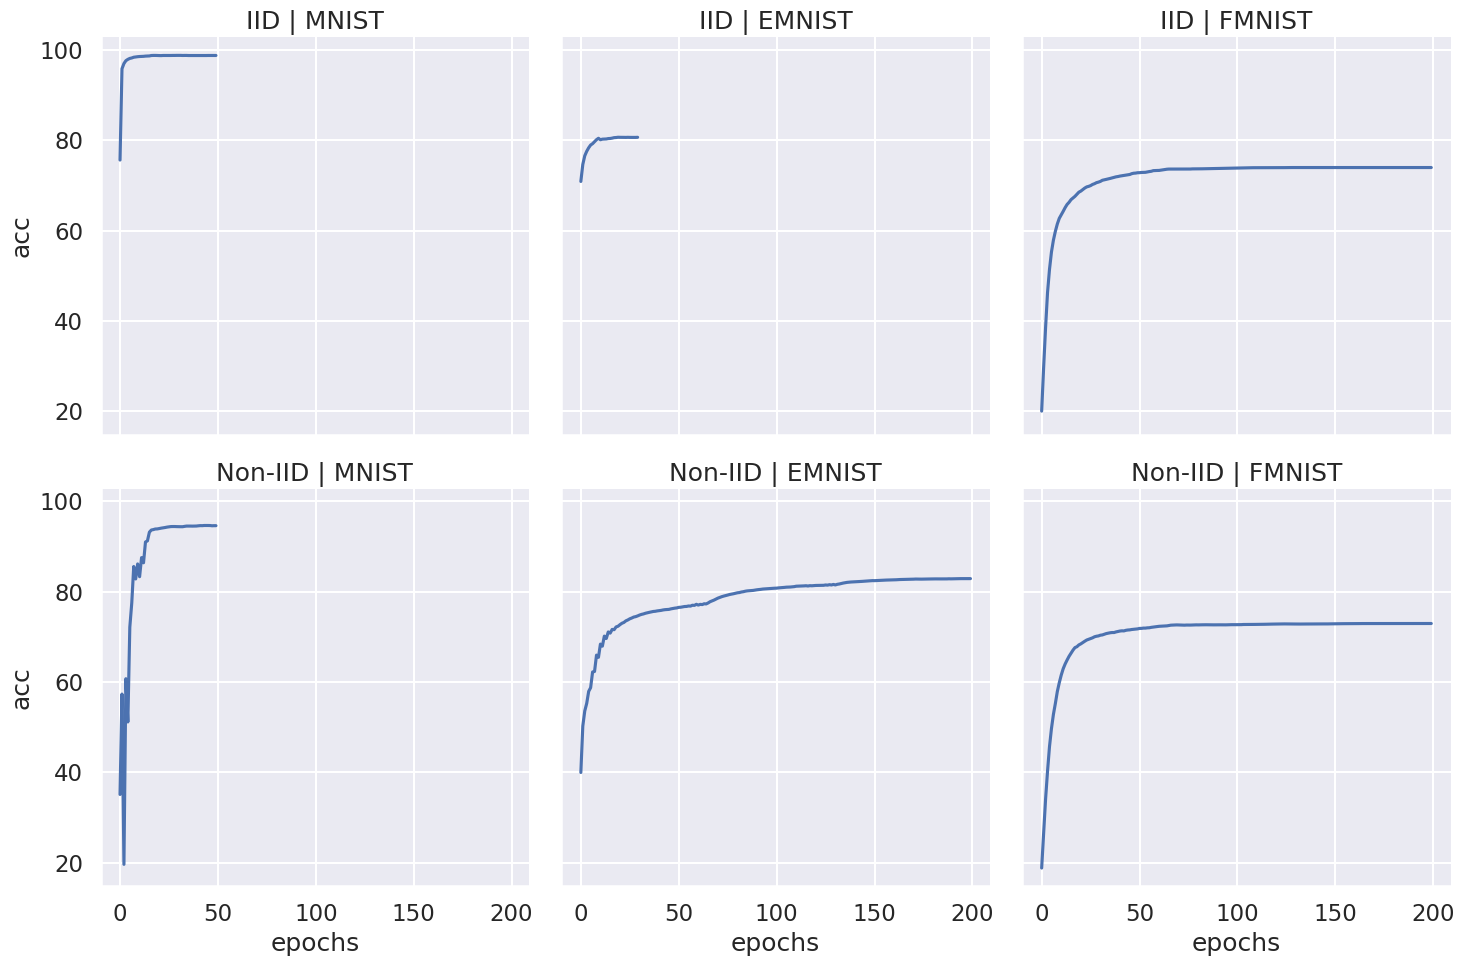

In [77]:
sns.set_theme(style='darkgrid')
sns.color_palette('colorblind')
sns.set_context('talk')
loss_plot = sns.relplot(
    data=train,
    x='epochs', y='loss', col='dataname', row='iid', 
    kind='line'
)
acc_plot = sns.relplot(
    data=server,
    x='epochs', y='acc', col='dataname', row='iid',
    kind='line'
)
for p in [loss_plot, acc_plot]:
    p.set_titles(col_template='{col_name}', row_template='{row_name}')
loss_plot.savefig('../train_loss.png')
acc_plot.savefig('../test_acc.png')